In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import matplotlib.lines as mlines
import scienceplots
import os
import soundfile as sf

# Definir estilo de las figuras con scienceplots
plt.style.use(["science", "grid"])
OUTPUT_FOLDER = os.path.join("plots")
FONT_SIZE = 14
plt.rcParams.update({
    'font.size': FONT_SIZE,           # Tamaño letra normal
    'axes.labelsize': FONT_SIZE,      # Tamaño letra labels
    'xtick.labelsize': FONT_SIZE,     # Tamaño letra eje X
    'ytick.labelsize': FONT_SIZE      # Tamaño letra eje Y
})

def save_fig(name):
    plt.savefig(os.path.join(OUTPUT_FOLDER, name+".pdf"), dpi=300)

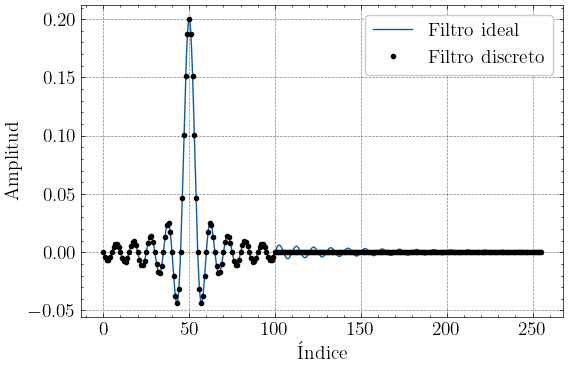

In [2]:
# Parámetros del primer filtro
L = 101
N = 256
FC = 0.1

# Filtro lowpass sinc 
def lowpass(x, fc):
    center = (L - 1) / 2
    return 2 * fc * np.sinc(2 * fc * (x - center))

# Creamos el filtro en [0,L], con padding hasta N
x = np.arange(N)
filter = lowpass(x[0:L], FC)
filter = np.append(filter, np.zeros(N - L))

# Curva sinc ideal para comparar
x_cont = np.linspace(0, N - 1, 5000)
ideal_filter = lowpass(x_cont, FC)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(x_cont, ideal_filter, '-', label='Filtro ideal', linewidth=1)
plt.plot(x, filter, 'o', markersize=3, label='Filtro discreto', color='black')
plt.xlabel("Índice")
plt.ylabel("Amplitud")
plt.grid(True)
plt.legend()
plt.tight_layout()
save_fig("lowpass_filter")
plt.show()

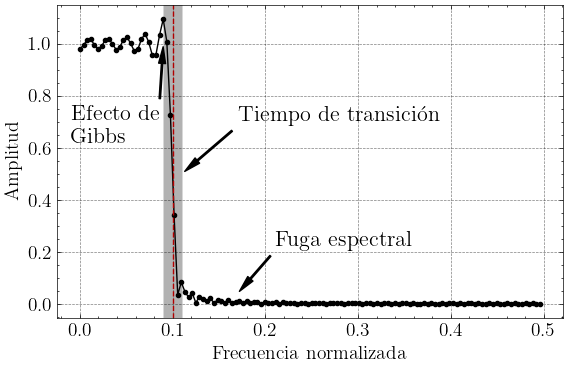

In [3]:
# FFT del filtro y frecuencias normalizadas
filter_fft = np.fft.fft(filter)
fft_freqs = np.fft.fftfreq(N, d=1)

# Plotteamos solo las frecuencias positivas
half_N = N // 2
plt.figure(figsize=(6, 4))
plt.plot(fft_freqs[:half_N], np.abs(filter_fft[:half_N]), color="black", linewidth=1,marker='o',markersize=3)

# Anotaciones
arrow_props = dict(facecolor='black', shrink=0.05, width=1, headwidth=5)
plt.axvline(FC, color='red', linestyle='--', linewidth=1)
plt.annotate('Efecto de \nGibbs', xy=(0.09, 1.0), xytext=(-0.01, 0.62),
             arrowprops=arrow_props,
             fontsize=16, color='black')
plt.annotate('Tiempo de transición', xy=(0.11, 0.5), xytext=(0.17, 0.7),
             arrowprops=arrow_props,
             fontsize=16, color='black')
plt.annotate('Fuga espectral', xy=(0.17, 0.04), xytext=(0.21, 0.22),
             arrowprops=arrow_props,
             fontsize=16, color='black')
plt.hlines(y=0.5, xmin=0.09, xmax=0.11, colors='black', linewidth=300, alpha=0.3)

# Labels y demás
plt.xlabel("Frecuencia normalizada")
plt.ylabel("Amplitud")
plt.grid(True)
plt.tight_layout()
save_fig("lowpass_spectrum")
plt.show()

/tmp/ipykernel_41126/79002045.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


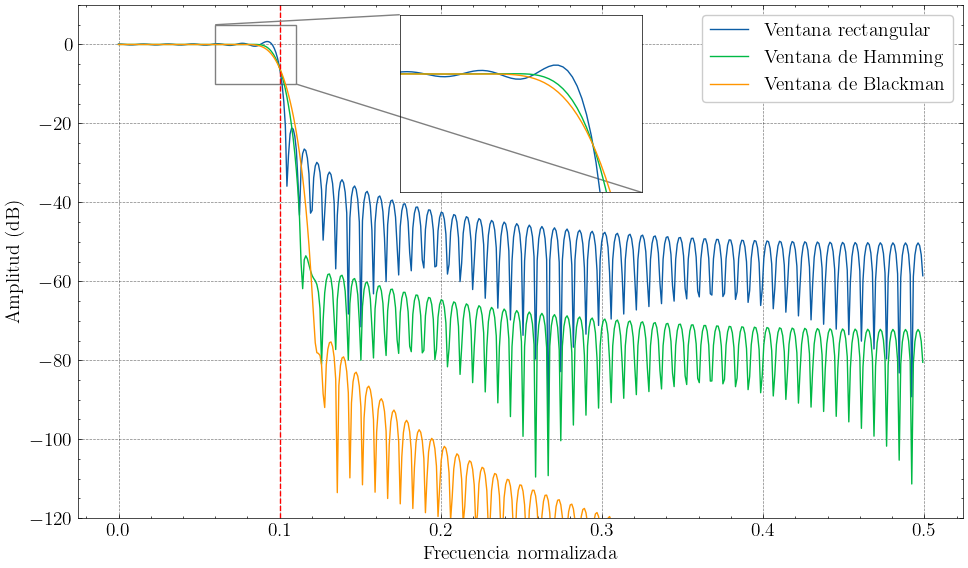

In [4]:
# Filtro más grande para esta visualización
N = 1024
L = 128

# Tipos de ventana
window_types = {
    "Ventana rectangular": np.ones(L),
    "Ventana de Hamming": windows.hamming(L),
    "Ventana de Blackman": windows.blackman(L),
}
# Eje de frecuencias
fft_freqs = np.fft.fftfreq(N, d=1)
half_N = N // 2
freq_half = fft_freqs[:half_N]


# Ejes figura principal
fig, ax = plt.subplots(figsize=(10, 6))
# Ejes del zoom en efecto Gibbs con zoomed inset axis
axins = zoomed_inset_axes(ax, zoom=3, loc='upper center')  # zoom=6x
x1, x2 = 0.06, 0.11
y1, y2 = -10, 5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.grid(True)
axins.set_xticks([])
axins.set_yticks([])
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="gray")

# Plots 
for name, window in window_types.items():
    x = np.arange(L)
    filter = lowpass(x, FC)
    windowed_filter = filter * window
    padded_filter = np.pad(windowed_filter, (0, N - L))
    fft_vals = np.fft.fft(padded_filter)
    magnitude_db = 20 * np.log10(np.abs(fft_vals[:half_N]) + 1e-12)
    ax.plot(freq_half, magnitude_db, label=name)
    axins.plot(freq_half, magnitude_db)

# Línea vertical en fc
ax.axvline(FC, color='red', linestyle='--', linewidth=1)
ax.set_xlabel("Frecuencia normalizada")
ax.set_ylabel("Amplitud (dB)")
ax.grid(True)
ax.set_ylim([-120, 10])
ax.legend()
plt.tight_layout()

# Guardar y mostrar
save_fig("ventanas_leakage")
plt.show()


In [5]:
# Leer archivo de audio en .wav
FILENAME = "d3guitar_e6piano.wav"
samples, fs = sf.read(FILENAME)

# Convertir a mono si es estéreo
if samples.ndim > 1:
    samples = samples.mean(axis=1)  # Promediar canales para convertir a mono

# Asegurar tipo float32
samples = samples.astype(np.float32)

# Frecuencia de muestreo y número de muestras
print("Frecuencia de muestreo:", fs, "Hz")
print("Número de muestras:", samples.size)

# FFT
spectrum = np.fft.fft(samples)
frequencies = np.fft.fftfreq(samples.size, d=1/fs)

# Resaltar harmónicos
max_linewidth = 6
min_linewidth = 1
decay_rate = 3.0
def plot_harmonics(harmonics, color, alpha=0.5):
    num_harmonics = len(harmonics)
    for i, freq in enumerate(harmonics, 1):
        if freq > frequencies.max():
            break
        x = (i - 1) / (num_harmonics - 1) if num_harmonics > 1 else 0
        lw = min_linewidth + (max_linewidth - min_linewidth) * np.exp(-decay_rate * x)
        plt.axvline(freq, color=color, alpha=alpha, linewidth=lw)

Frecuencia de muestreo: 48000 Hz
Número de muestras: 118700


In [6]:
def fft_convolve(a, b, mode):
    # Tamaño final de la salida
    n = len(a) + len(b) - 1
    # FFT con relleno con zeros
    A = np.fft.fft(a, n)
    B = np.fft.fft(b, n)
    # Producto elemento a elemento
    C = A * B
    # FFT inversa para obtener el array de salida
    # Cogemos la parte real, la imaginaria debería ser 0,
    # pero la quitamos explicitamente por si hay errores numéricos
    c = np.fft.ifft(C).real
    if mode == 'full':
        return c
    elif mode == 'same':
        start = (len(b) - 1) // 2
        end = start + len(a)
        return c[start:end]
    else:
        raise ValueError("mode must be 'full' or 'same'")

Tamaño final del filtro: 40001


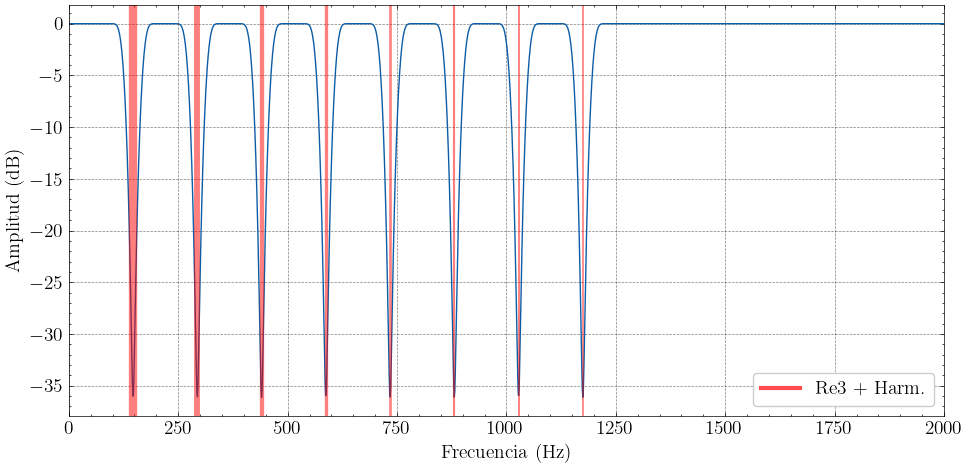

In [7]:
# Frecuencias fundamentales de los 2 tonos
D3_FREQ = 146.83  
E6_FREQ = 1318.51

# Harmónicos
harmonics_d3 = [D3_FREQ * i for i in range(1, 9)]
harmonics_e6 = [E6_FREQ * i for i in range(1, 7)]

# Correción (aproximada) de los harmónicos del piano
for i in range(2, 6):
    harmonics_e6[i] += 95*(i-1)
harmonics_e6[3] += 10
harmonics_e6[4] += 110

# Radio de los filtros de banda y longitud del filtro
BAND_RADIUS = 20
kernel_len = 5001
S = kernel_len // 2

# Plot de la magnitud en dB
def plot_filter(save = False, name = ""):
    # Use real FFT and corresponding frequency bins
    H = np.fft.fft(h_harmonics)
    frequencies = np.fft.fftfreq(h_harmonics.size, d=1/fs)
    mask = frequencies >= 0
    frequencies = frequencies[mask]
    H = H[mask]
    plt.figure(figsize=(10, 5))
    plt.plot(frequencies, 20 * np.log10(np.abs(H) +1e-12))
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Amplitud (dB)")
    plt.grid(True)
    plt.xlim(0, 2000)  # Focus on low-frequency range
    plot_harmonics(harmonics_d3, color='red')
    green_line = mlines.Line2D([], [], color='red', linewidth=3, alpha=0.7, label='Re3 + Harm.')
    plt.legend(handles=[green_line])
    plt.tight_layout()
    if save:
        save_fig(name)
    plt.show()

# Construcción del filtro de harmónicos
h_harmonics = 0
delta = np.zeros(kernel_len)
delta[S] = 1
for i, fft_freqs in enumerate(harmonics_d3):
    fc_low = fft_freqs - BAND_RADIUS
    fc_high = fft_freqs + BAND_RADIUS
    t = np.arange(-S, S+1)
    h_low = 2 * fc_low / fs * np.sinc(2 * fc_low * t / fs)
    h_low *= np.blackman(kernel_len)
    h_high = 2 * fc_high / fs * np.sinc(2 * fc_high * t / fs)
    h_high *= np.blackman(kernel_len)
    # Inversión espectral para el filtro de banda
    h_bandreject = h_low + (delta - h_high)

    # Convolución acumulada para crear el filtro completo
    if i == 0:
        h_harmonics = h_bandreject
    else:
        h_harmonics = fft_convolve(h_harmonics, h_bandreject, mode='full')

print("Tamaño final del filtro:", h_harmonics.size)
plot_filter(save=True, name="harmonics_filter")

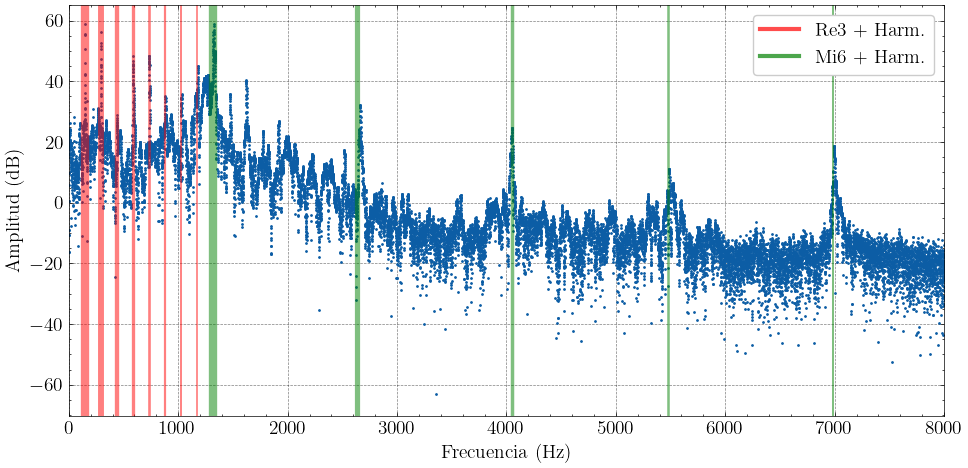

In [8]:

# Plot principal
plt.figure(figsize=(10, 5))
plt.plot(frequencies, 20 * np.log10(np.abs(spectrum) + 1e-12), linewidth=0, marker='o', markersize=1)
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud (dB)")
plt.grid(True)
plt.xlim(0, 8000)  # Focus on low-frequency range

plot_harmonics(harmonics_d3, color='red')
plot_harmonics(harmonics_e6, color='green')

# Líneas para la leyenda
green_line = mlines.Line2D([], [], color='red', linewidth=3, alpha=0.7, label='Re3 + Harm.')
red_line = mlines.Line2D([], [], color='green', linewidth=3, alpha=0.7, label='Mi6 + Harm.')

plt.legend(handles=[green_line, red_line])

plt.tight_layout()
save_fig("spectrum_notes")
plt.show()


In [9]:
# Convolución del filtro
filtered = fft_convolve(samples, h_harmonics, mode='same')

# Normalización al rango [-1, 1] para evitar distorsión en el audio
filtered = filtered / np.max(np.abs(filtered))

# Exportar el audio procesado
sf.write("piano_filtrado.wav", filtered, fs)

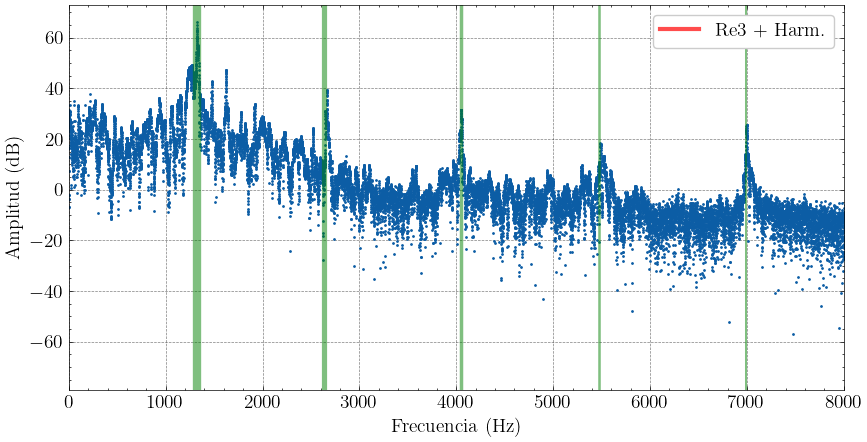

In [10]:
# Espectro tras el filtrado, sin picos de frecuencias de la guitarra
spectrum = np.fft.fft(filtered)
frequencies = np.fft.fftfreq(filtered.size, d=1/fs)

plt.figure(figsize=(10, 5))
plt.plot(frequencies, 20 * np.log10(np.abs(spectrum) + 1e-12), linewidth=0, marker='o', markersize=1)
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud (dB)")
plt.grid(True)
plt.xlim(0, 8000)
plot_harmonics(harmonics_e6, color='green')

# Líneas para la leyenda
green_line = mlines.Line2D([], [], color='red', linewidth=3, alpha=0.7, label='Re3 + Harm.')

plt.legend(handles=[green_line])